In [2]:
import sys, os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

sys.path.append('/content/drive/My Drive/Radiomics Workshop')
os.chdir('drive/My Drive/Radiomics Workshop')

Mounted at /content/drive


In [3]:
!pip install lifelines

     |████████████████████████████████| 348kB 2.9MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=fb5db7eb36463362c4263b160449255b2066c41fb86d83eb55c203c1281c8a67
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


Got data
Reduction complete
Clustering done


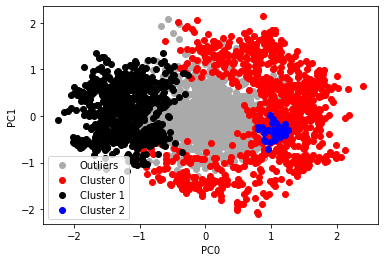

Counter({-1: 1422, 0: 829, 1: 709, 2: 37})


In [25]:
import pandas as pd
import numpy as np
import scipy
import torch
import math
import lifelines
from os.path import exists
from google.colab import drive
from lifelines.statistics import logrank_test
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration as FA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import wasserstein_distance as wass
from collections import Counter
from utils import tensors_as_images

LABEL_COLOR_MAP = {-1 : '#aaaaaa',
                  0 : 'r',
                  1 : 'k',
                  2 : 'b',
                  3 : 'g',
                  4 : '#00ff88',
                  5 : '#8800ff',
                  6 : '#88ff00',
                  7 : '#ff8800',
                  8 : '#0088ff'}


def prepare_data(df, start=28):
  # Get a feature matrix from a DF
  columns = list(df.keys()[start:])
  data = df[columns].to_numpy()
  np.nan_to_num(data,0)
  scaler = StandardScaler() 
  data = scaler.fit_transform(data)
  return data

def reduce_dim(data, num_components, method):
  # All reduction methods are defined here.
  assert method == "fa" or method == "pca"
  if method == "fa":
    model = FA(num_components, affinity='cosine', linkage='complete')
  if method == "pca":
    model = PCA(num_components)
  reduced = model.fit_transform(data)
  return reduced

def cluster_data(data, eps, min_samples):
  # DBSCAN clustering algorithm (see paper)
  dist = cosine_distances(data)
  model = cluster.DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples).fit(dist)
  labels = model.labels_
  return model, labels

def visualize_clusters(reduced, labels, folder_name):
  # Creates a scatter plot where each group is differently colored.
  reduced_t = reduced.transpose()
  label_color = [LABEL_COLOR_MAP[l] for l in labels]
  fig, ax = plt.subplots()
  for i in LABEL_COLOR_MAP.keys():
    label = LABEL_COLOR_MAP[i]
    cluster = np.array([[reduced_t[0][j],reduced_t[1][j]] for j in range(len(reduced_t[0])) if label_color[j] == label])
    if(len(cluster) == 0):
      continue
    cluster = cluster.transpose()
    label_name = f"Cluster {i}" if i >= 0 else "Outliers"
    ax.scatter(cluster[0], cluster[1], c=label, label=label_name)
  ax.legend()
  ax.set_xlabel("PC0")
  ax.set_ylabel("PC1")
  plt.savefig(f"{folder_name}/scatter_plot")
  plt.show()

def prepare_results(df, labels, names):
  # Creates a DF where each patch has its group
  columns = list(df.keys()[:names])
  df_clusters = df[columns].copy()
  df_clusters['Clusters'] = labels
  return df_clusters

def normalize_dict(d):
  # Normalizes the cluster values in a dict to be distributions
  for item in d.keys():
    sum = 0
    for key in d[item].keys():
      sum += d[item][key]
    for key in d[item].keys():
      d[item][key] /= sum
  return d

def dict_to_groups(d):
  # Creates a DF where for each element the clusters are 1 where the distribution is bigger than average, and 0 otherwise
  initial_df = pd.DataFrame.from_dict(d, orient='index').fillna(0)
  means = initial_df.mean(axis=0)
  groups_df = initial_df.where(initial_df >= means).notnull().astype('int')
  return groups_df

def plotPopulations(df, kmf, groups, clusters, folder):
  # KM plotting and result printing
    for c in clusters:
      g = (groups[c] == 1)
      kmf.fit(T[g], E[g], label=f'Group {c}')
      kmf.plot(ci_show=False)
      print(f"Group {c} vs Non-Group {c} results:")
      print()
      results = logrank_test(T[g], T[~g], E[g], E[~g], alpha=.99, weightings='wilcoxon')
      results.print_summary()
      print("P Value:", results.p_value)
      print("Test statistic:", results.test_statistic)
      print()
    plt.savefig(f"{folder}/kaplan_meier_plot")

# ==========
# PARAMETERS
# ==========

task = 'segmentation' # can be one of: classification_2d, classification_3d, segmentation

epsilons = {'classification_2d' : 0.2475, 'classification_3d':0.10133, 'segmentation':0.39479} # These are the recommended values for epsilon.
epochs = {'classification_2d' : 12, 'classification_3d':13, 'segmentation':67}
epoch = epochs[task]
epsilon = 0.2
min_samples = 50 # Recommended: 50 for 2D and 10 for 3D
num_components = int(min_samples / 2) # It is recommended for min_samples to be 2 * data dimension.

# Make folder

folder_name = f"results/clustering/{task}/eps_{epsilon}_minsamples_{min_samples}"
net = f'results/features/{task}_features_from_model_{epoch}_epochs.csv'

if not os.path.isdir(folder_name):
  os.mkdir(folder_name)

# Get data

df = pd.read_csv(net, sep=',')
data = prepare_data(df, start=6)
micelines = pd.read_csv('datasets/survival_withMP.csv', sep=',').drop(["CC/FVBN"], axis=1)
print("Got data")

# Reduce to lower dimension

reduced = reduce_dim(data, num_components=num_components, method="fa")
visualize = reduce_dim(reduced, num_components=2, method="pca")
print("Reduction complete")

# Cluster reduced data

clusters, labels = cluster_data(reduced, epsilon, min_samples)
print("Clustering done")
visualize_clusters(visualize, labels, folder_name)
print(Counter(labels))


Results:

Group 0 vs Non-Group 0 results:



<lifelines.StatisticalResult: Wilcoxon_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = Wilcoxon_test

---
 test_statistic    p  -log2(p)
           6.10 0.01      6.21

P Value: 0.013535198613802917
Test statistic: 6.097777777777776

Group 1 vs Non-Group 1 results:



<lifelines.StatisticalResult: Wilcoxon_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = Wilcoxon_test

---
 test_statistic    p  -log2(p)
           1.48 0.22      2.16

P Value: 0.22353639360789457
Test statistic: 1.4815229563269876

Group 2 vs Non-Group 2 results:



<lifelines.StatisticalResult: Wilcoxon_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = Wilcoxon_test

---
 test_statistic    p  -log2(p)
           1.65 0.20      2.33

P Value: 0.1992163752828511
Test statistic: 1.648109928307625



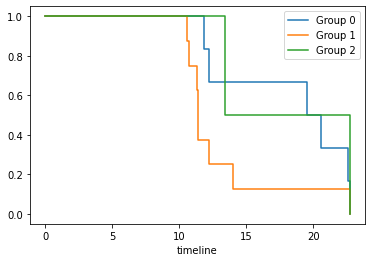

In [26]:
# Create cluster counts CSV

df_clusters = prepare_results(df, labels, 6)
df_clusters.to_csv(f'{folder_name}/clusters.csv')
mice = df_clusters.groupby(["Name", "Clusters"]).count().drop(['Slices', 'Patch', 'Tumor %', 'Path'], axis=1).rename({"Unnamed: 0" : "Count"}, axis=1)
mice.to_csv(f'{folder_name}/cluster_count_per_mouse.csv')

# Translate DF to dict

mice_dict = {}
for item in mice.iterrows():
  mouse_num = int(item[0][0][2:6])
  cluster = item[0][1]
  if mouse_num not in mice_dict.keys():
    mice_dict[mouse_num] =  {cluster:0}
  if cluster not in mice_dict[mouse_num].keys():
    mice_dict[mouse_num][cluster] =  0
  mice_dict[mouse_num][cluster] = item[1].Count

# Process lines and survival DF

micelines = micelines.drop(micelines[micelines.CC_line == 0].index)
unknown_mice = [mouse for mouse in micelines.mouseID.values if not mouse in list(mice_dict.keys())]
micelines = micelines.set_index('mouseID')
for i in range(len(unknown_mice)):
  micelines = micelines.drop(unknown_mice[i], axis=0)

mice_dict = normalize_dict(mice_dict)
mice_groups_df = dict_to_groups(mice_dict)
unknown_mice = [mouse for mouse in list(mice_dict.keys()) if not mouse in micelines.index]
mice_groups_df = mice_groups_df.drop(unknown_mice, axis=0)

# Create cluster counts per line dict and CSV

lines = {}
names = []
mice_dict = mice_groups_df.to_dict()
for item in micelines.iterrows():
  line = str(int(item[1].CC_line))
  name = item[0]
  names.append(name)
  if name not in mice_dict[-1].keys():
    continue
  if line not in lines.keys():
    lines[line] = {cluster:0 for cluster in mice_dict.keys()}
  for cluster in lines[line].keys():
    lines[line][cluster] += mice_dict[cluster][name]

lines = normalize_dict(lines)
lines_groups_df = dict_to_groups(lines)

# Save CSVs

mice_groups_df.to_csv(f'{folder_name}/mice_clusters.csv')
lines_groups_df.to_csv(f'{folder_name}/lines_clusters.csv')

# print examples from each group (if 2D) and measure tumor % for each

# n=80
# end = 10

clusters = [i for i in range(np.max(labels) + 1)]

# for c in clusters:
#   cluster_df = df_clusters.drop(df_clusters[df_clusters.Clusters != c].index)
  
#   if task != 'classification_3d':
#     cluster = []
#     for item in cluster_df['Unnamed: 0']:
#       image = torch.load(cluster_df['Path'][item].strip("]").strip("[").strip("\'").replace('\\u200f\\u200f', '\u200f\u200f'))['image']
#       cluster.append(image)
#       if len(cluster) == end:
#         break
#     tensors_as_images(cluster, figsize=(n,n))
#   print("Group", c, "Tumor % mean:", cluster_df.mean(axis=0)['Tumor %'])

# Prepare results for KM

T = micelines['Survival']
E = micelines['Event']

kmf = lifelines.KaplanMeierFitter()
kmf.fit(T, E)
print()
print("Results:")
print()

# Plot Kaplan-Meier graph
plotPopulations(micelines, kmf, mice_groups_df, clusters, folder_name)